In [2]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
%matplotlib inline
import random as rd
from IPython.display import clear_output #allows us to animate results

np.set_printoptions(threshold=np.inf)

In [3]:
#Below is the code to run trials 1-3 of the Muci model

In [72]:
#Variables

#Bacterial parameters given in paper
tStasis = 10 #time limit for starvation
t = 150 #bacterial generations (Originally 300)
alpha = 10 #Upper limit of nutrients for feeding bacteria
beta  = 5 #lower limit of nutrients for feeding bacteria
gamma = 6 #fitness level for reproduction
K2 = 4 #increase in fitness
K1 = -4 #decrease in fitness
starve = 2 #starvation threshold



#Environmental parameters
Bmax = 40 #maximum possible number of bacteria per cell (Use 400 for trial 1, 40 for trials 2 and 3)
Nmax = 1000 #maximum nutrient level in a cell (use 15k for T1, 8k for T2, 1k for T3)
m = 10 # automata width (originally 15, changed to shorten run time)
n = 75 #automata height  (originally 125)
pHmin = 4.5 #min pH for bacteria
pHmax = 6.5 #max pH for bacteria
CCmax = 5 #opitmal nutrient consumption rate

#initial Nutrient, Bacteria, and pH storage matrices. Also includes fitness and starvation storage
Nstor = np.full((n,m), Nmax)
Bstor = np.zeros([n,m])
BTstor = np.zeros([t,n,m])
Bstor[0,3] = 1
Pstor = pHmax * np.random.rand(n, m)
Fstor = np.zeros((n, m, Bmax))
Sstor = np.zeros((n, m, Bmax))


In [73]:
#identifies neighbors of a cell xy
def position(root,x,y):
    
    rows, cols = root.shape
    center = root[x,y]
    
    #all possible neighbors
    left= root[x, (y-1)%cols]
    right = root[x,(y+1)%cols]
    up = root[(x-1)%rows, y]
    down = root[(x+1)%rows,y]
    upLeft = root[(x-1)%rows, (y-1)%cols]
    downLeft = root[(x+1)%rows, (y-1)%cols]
    upRight = root[(x-1)%rows, (y+1)%cols]
    downRight = root[(x+1)%rows, (y+1)%cols]
    across = root[x, (round(y+(cols/2))%cols) ]
    
    #general case neighborhood
    aboutCenter = np.array([
                    [upLeft, up, upRight],
                    [left, 0, right],
                    [downLeft, down, downRight]])
    # special case that prevents bacteria from populating cells[-x,-y] when root has a length of 1
    if x == 0:
        aboutCenter = np.array([
                    [0,0,0],
                    [left, 0, right],
                    [downLeft,down,downRight]])
    # special case that prevents bacteria in cell -x,-y from populating row 0. 
    # Also introduces accross to simulate cone shaped root tip 
    if x == rows-1:
           aboutCenter =  np.array([
                    [upLeft, up, upRight],
                    [left, across, right],
                    [0,0,0]])
    return(aboutCenter)

In [6]:
#converts array indexing to cartesian coordinates
def candToXnYn(x, y):
    if x.ndim !=0 and y.ndim!=0:
        x = x[0]
        y = y[0]
    
    if x == 0:
        Xn = -1
    if x == 1:
        Xn = 0
    if x == 2:
        Xn = 1
    if y == 0:
        Yn = -1
    if y == 1:
        Yn = 0
    if y == 2:
        Yn = 1
    return(Xn,Yn)

In [7]:
#determines how fitness of a single bacterium changes at i+1
def KN(n):
    if n == 1:
        K = K1
    if n == 2: #there was ambiguity on how the bacterium should behave at n = 2 in the paper, this is my assumption
        K = 0 
    if n == 3:
        K = K2
    return(K)

In [8]:
#allows bacterium to be removed from an array without changing the starvation and fitness values of subsequent bacteria
#array input MUST specify dimension if using a 3D array and must be saved as same z value of array being modified
def shift(shiftFrom, array):

    arr = np.delete(array,shiftFrom)
    arr = np.append(arr,0)
   
    return(arr)

In [118]:
#Regeneration of important bacterial arrays and matrices
Nstor = np.full((n,m), Nmax) #matrix 
Bstor = np.zeros([n,m])#initial bacteria population of 1 at the center of the forming root tip
Bstor[0,3]  = 1
Pstor = np.full((n,m), pHmax) #matrix that stores root's pH
Fstor = np.full((n, m, Bmax), 2)#matrix with values >starve to avoid entering stasis immediately after birth
Sstor = np.full((n,m,Bmax), 0) #matrix that holds starvation count for each bacterium
Acount = np.zeros(t)
Scount = np.zeros(t)

#Variables and matrices for root growth
R0 = 1250
time = np.linspace(0,t,t)
U = (-1/300)
root = np.zeros([n,m])
root[0,:] = 1


#For loop that grows root depending on root growth equation and generations
for i in range(0,time.size):
    
    #Governs root growth
    
    L = R0*(1-(2.71828)**(U*(time[i])))
    root[0:int(np.round(L)),:] = 1
#     root = np.ones([n,m]) #To run model 2, uncomment this line and comment lines 24 and 25
#for loop that examines each possible cell xy
    for x in range(0,n):
        for y in range(0,m):
            
            #Tracks total reproduction events per cell
            repCounter = 0          
            
            #Checks for root to colonize
            if root[x,y] == 1: 
                
                
                #catalogs number of bacteria within cell xy
                Bxy = int(Bstor[x,y])
                
                #caps population of cell xy at Bmax
                
                if Bxy > Bmax:
                    Bstor[x,y] = Bmax                    
                    Bxy = Bmax
                if Bxy == 0:
                    Bstor[x,y] = 1                    
                    Bxy = 1
                #for loop that checks each bacteria for suitability to reproduce
                for Bi in range(0,Bxy):
                   
                #Updates N:B for each bacterium
                    NBstor = np.divide(Nstor,Bstor)
                    NBxy = int(NBstor[x,y]) +1
                    
                    #consumption potential of bacterium Bi
                    CC = min(NBxy, CCmax)
                    
                    if CC != 0:
                    
                    #Determines how a bacterium's fitness will change in gen i+1
                        if NBxy >= alpha:
                            N = 3
                        if alpha> NBxy > beta:
                            N = 2
                        if beta > NBxy:
                            N = 1
                        NBneighbor = position(NBstor, x, y)
                        CC = min(NBxy, CCmax)
                        
                        #Calls on the bacterium's position Bi within the storage and fitness arrays
                        Sxy = int(Sstor[x, y, Bi]) 
                        Fxy = int(Fstor[x, y, Bi])
                        
                        #Locates cell adjacent to Bxy with best N:B 
                        bestRatio = np.max(NBneighbor)
                        candidate = np.where(NBneighbor == bestRatio)
                        
                        #Translates candidate coordinates to grid where Bxy is position 0,0
                        Xn, Yn = candToXnYn(candidate[0], candidate[1])
                        #Determines pH of cell
                        Pxy = Pstor[x,y]
                        #Determines pH of candidate cell
                        candPH = Pstor[x+Xn,(y+Yn)%m]
                        
                        #reproduction pathway
                        if pHmax >= candPH > pHmin and Sxy ==0 and root[x+Xn,(y+Yn)%m]== 1:
                            
                            #checks for appropriate fitness and candidate cell pop < Bmax
                            if Fxy >= gamma and Bstor[x+Xn, (y+Yn)%m] != Bmax:
                                
                                #halves fitness of Bi to represent cell fission
                                Fstor[x, y, Bi] = (Fxy/2)
                                
                                #bacterium added to candidate cell
                                Bstor[x+Xn, (y+Yn)%m] = Bstor[x+Xn, (y+Yn)%m] +1
                                
                                
                                
                                repCounter +=1
                            
                            #if candidate cell is full, no reproduction occurs to prevent overflowing 
                            elif Fxy >= gamma and Bstor[x+Xn, (y+Yn)%m] == Bmax:
                                
                                Fstor[x, y, Bi] = (Fxy/2)
                                
                            
                            #Bacteria changes fitness if conditions are not suitable for reproduction or starvtion
                            elif starve <= Fxy < gamma:
                                
                                Fstor[x, y, Bi] = Fxy +KN(N)
                                Nstor[x,y] -= CC
                                Sstor[x,y,Bi] = 0
                            #starvation counter increased by 1 when fitness does not pass threshold
                            if Fxy < starve:
                                
                                Sstor[x, y, Bi] += 1
                                Fstor[x, y, Bi] = Fxy +KN(N)
                            #Starvation
                            if Sxy >= tStasis:
                                #shifts values in starvation and fitness arrays to represent death
                                Sstor[x, y,:] = shift(Bi, Sstor[x,y,:])
                                Fstor[x, y,:] = shift(Bi, Fstor[x,y,:])
                               
                                Bstor[x,y] = Bstor[x,y]-1
                            
                            
                        
                        # poor pH pathway, fitness and starvation can change, reproduction no longer possible         
                        else:
                            
                            #fitness adjustment
                            if starve <= Fxy < gamma:
                                
                                Fstor[x, y, Bi] = Fxy +KN(N)
                                Nstor[x,y] -= CC
                                Sstor[x,y,Bi] = 0
                            
                            #Starvation
                            if Fxy < starve:
                                
                                Sstor[x, y, Bi] += 1
                                Fstor[x, y, Bi] = Fxy +KN(N)
                            #Starvation
                            if Sxy >= tStasis:
                                
                                Sstor[x, y,:] = shift(Bi, Sstor[x,y,:])
                                Fstor[x, y,:] = shift(Bi, Fstor[x,y,:])
                               
                               
                                Bstor[x,y] = Bstor[x,y]-1
                
                
                print("Investigating cell",x,y, "\nGeneration",i)
                clear_output(wait = True)
                #Rapid reproduction degrades environmental pH  
            
            
            
            if repCounter >= 4:
                Pstor[x,y] = Pstor[x,y]-.1

                              

                    
#The if statement below allows for periodic root exudate release into the environment.
#Uncomment the line below and change variables to T3 settings to run trial 3.

    if i == 18 or 36 or 54 or 72 or 90 or 108 or 126 or 144:
        Nstor = np.add(Nstor, Bmax*2)
    BTstor[i,:,:] = Bstor
    Acount[i] = np.count_nonzero(Fstor>starve)
    Scount[i] = np.count_nonzero(starve>Fstor)


Investigating cell 74 9 
Generation 149


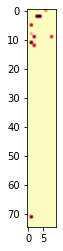

In [110]:
#initial bacteria count
plt.imshow(BTstor[95,:,:
                 ], cmap = 'magma')

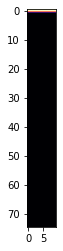

In [119]:
plt.imshow(BTstor[0,:,:], cmap = 'magma')

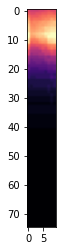

In [120]:
#early stages of bacterial colonization
plt.imshow(BTstor[10,:,:
                 ], cmap = 'magma')

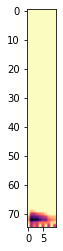

In [121]:
plt.imshow(BTstor[25,:,:
                 ], cmap = 'magma')

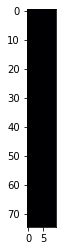

In [122]:
#roughly halfway through point in model where observable change still occurs
plt.imshow(BTstor[40,:,:
                 ], cmap = 'magma')

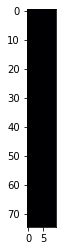

In [123]:

#End state of bacteria, pattern repeats from here until end of simulation
plt.imshow(BTstor[55,:,:
                 ], cmap = 'magma')

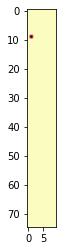

In [124]:
plt.imshow(BTstor[85,:,:], cmap = 'magma')

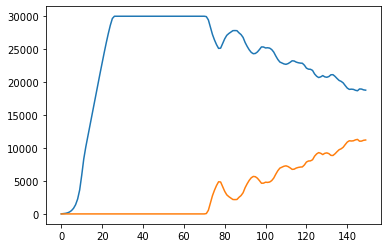

In [125]:
#plots count of active bacteria (fitness > starve) and count of bacteria in starving state
#Unfortunately, I could not recreate this graph because the method I emplemented to track fitness and starvation
#and I could not find or figure out how to design a function that could track active count and starvation count.
#At some point along development Scount ceased tracking starvation count and I could not figure out why it didn't
# work while Acount did despite them utilizing the exact same method to track activity and starvation.
#This is as close as I could come to recreating the graph.
plt.plot(Acount)
plt.plot(Scount)

In [431]:
#Below are variables to run the two trials of our experiment to replicate Ankati's data
#Variables

#Bacterial parameters given in paper
tStasis = 10 #time limit for starvation
t = 25 #bacterial generations
alpha = 1 #Upper limit of nutrients for feeding bacteria
beta  = 5 #lower limit of nutrients for feeding bacteria
gamma = 4 #fitness level for reproduction
K2 = 6 #increase in fitness
K1 = -4 #decrease in fitness
starve = 2 #starvation threshold
theta = 4#average sum of bacteria in bottom row required to promote root growth
PC = 10 #optimal consumption potential of plant

#Environmental parameters
Bmax = 10 #maximum possible number of bacteria per cell (originally 400)
Nmax = 200 #maximum nutrient level in a cell, alt values are 10k and 15k
m = 10 # automata width (originally 15, changed to shorten run time)
n = 500 #automata height  (originally 125)
pHmin = 4.5 #min pH for bacteria
pHmax = 6.5 #max pH for bacteria
CCmax = 5 #opitmal nutrient consumption rate

#initial Nutrient, Bacteria, and pH storage matrices. Also includes fitness and starvation storage
Nstor = np.full((n,m), Nmax)
Bstor = np.zeros([n,m])
R1stor = np.zeros([t,n,m])
R2stor = np.zeros([t,n,m])
Bstor[0,3] = 1
Pstor = pHmax * np.random.rand(n, m)
Fstor = np.zeros((n, m, Bmax))
Sstor = np.zeros((n, m, Bmax))


In [497]:

#Changes in this model from Muci's, bacteria are presumed to constantly replicate because of high 
#root exudate concentration and therefore the plant is expected to grow at the increase reate R1 for the
#duration of the simulation. Otherwise, our attempt at implementing Muci's model is preserved

#Regeneration of important bacterial arrays and matrices
Nstor = np.full((n,m), Nmax) #matrix 
Bstor = np.full([n,m],3)#initial bacteria population evenly dispersed within soil to mimic bacteriazation of soil

Pstor = np.full((n,m), pHmax) #matrix that stores root's pH
Fstor = np.full((n, m, Bmax), 3)#matrix with values >starve to avoid entering stasis immediately after birth
Sstor = np.full((n,m,Bmax), 0) #matrix that holds starvation count for each bacterium


#Variables and matrices for root growth

R1 = 2125 
time = np.linspace(0,t,t)
U = (-1/300)
root1 = np.zeros([n,m])
root1[0,:] = 1


#For loop that grows root depending on root growth equation and generations
for i in range(0,time.size):
    
    
    L = R1*(1-(2.71828)**(U*(time[i])))
    root1[0:int(np.round(L)),:] = 1
#     root = np.ones([n,m])
#for loop that examines each possible cell xy
    for x in range(0,n):
        for y in range(0,m):
            
            #Tracks total reproduction events per cell
            repCounter = 0          
            
            #Checks for root to colonize
            if root1[x,y] == 1: 
                
                
                #catalogs number of bacteria within cell xy
                Bxy = int(Bstor[x,y])
                
                #caps population of cell xy at Bmax
                
                if Bxy > Bmax:
                    Bstor[x,y] = Bmax                    
                    Bxy = Bmax
                if Bxy == 0:
                    Bstor[x,y] = 1                    
                    Bxy = 1
                #for loop that checks each bacteria for suitability to reproduce
                for Bi in range(0,Bxy):
                   
                #Updates N:B for each bacterium
                    NBstor = np.divide(Nstor,Bstor)
                    NBxy = int(NBstor[x,y]) +1
                    
                    #consumption potential of bacterium Bi
                    CC = min(NBxy, CCmax)
                    
                    if CC != 0:
                    
                    #Determines how a bacterium's fitness will change in gen i+1
                        if NBxy >= alpha:
                            N = 3
                        if alpha> NBxy > beta:
                            N = 2
                        if beta > NBxy:
                            N = 1
                        NBneighbor = position(NBstor, x, y)
                        CC = min(NBxy, CCmax)
                        
                        #Calls on the bacterium's position Bi within the storage and fitness arrays
                        Sxy = int(Sstor[x, y, Bi]) 
                        Fxy = int(Fstor[x, y, Bi])
                        
                        #Locates cell adjacent to Bxy with best N:B 
                        bestRatio = np.max(NBneighbor)
                        candidate = np.where(NBneighbor == bestRatio)
                        
                        #Translates candidate coordinates to grid where Bxy is position 0,0
                        Xn, Yn = candToXnYn(candidate[0], candidate[1])
                        #Determines pH of cell
                        Pxy = Pstor[x,y]
                        #Determines pH of candidate cell
                        candPH = Pstor[x+Xn,(y+Yn)%m]
                        
                        #reproduction pathway
                        if pHmax >= candPH > pHmin and Sxy ==0 and root1[x+Xn,(y+Yn)%m]== 1:
                            
                            #checks for appropriate fitness and candidate cell pop < Bmax
                            if Fxy >= gamma and Bstor[x+Xn, (y+Yn)%m] != Bmax:
                                
                                #halves fitness of Bi to represent cell fission
                                Fstor[x, y, Bi] = (Fxy/2)
                                
                                #bacterium added to candidate cell
                                Bstor[x+Xn, (y+Yn)%m] = Bstor[x+Xn, (y+Yn)%m] +1
                                
                                
                                
                                repCounter +=1
                            
                            #if candidate cell is full, no reproduction occurs to prevent overflowing 
                            elif Fxy >= gamma and Bstor[x+Xn, (y+Yn)%m] == Bmax:
                                
                                Fstor[x, y, Bi] = (Fxy/2)
                                
                            
                            #Bacteria changes fitness if conditions are not suitable for reproduction or starvtion
                            elif starve <= Fxy < gamma:
                                
                                Fstor[x, y, Bi] = Fxy +KN(N)
                                Nstor[x,y] -= CC
                                Sstor[x,y,Bi] = 0
                            #starvation counter increased by 1 when fitness does not pass threshold
                            if Fxy < starve:
                                
                                Sstor[x, y, Bi] += 1
                            
                            #Starvation
                            if Sxy >= tStasis:
                                #shifts values in starvation and fitness arrays to represent death
                                Sstor[x, y,:] = shift(Bi, Sstor[x,y,:])
                                Fstor[x, y,:] = shift(Bi, Fstor[x,y,:])
                               
                                Bstor[x,y] = Bstor[x,y]-1
                            
                            
                        
                        # poor pH pathway, fitness and starvation can change, reproduction no longer possible         
                        else:
                            
                            #fitness adjustment
                            if starve <= Fxy < gamma:
                                
                                Fstor[x, y, Bi] = Fxy +KN(N)
                                Nstor[x,y] -= CC
                                Sstor[x,y,Bi] = 0
                            
                            #Starvation
                            if Fxy < starve:
                                
                                Sstor[x, y, Bi] += 1
                            
                            #Starvation
                            if Sxy >= tStasis:
                                
                                Sstor[x, y,:] = shift(Bi, Sstor[x,y,:])
                                Fstor[x, y,:] = shift(Bi, Fstor[x,y,:])
                               
                               
                                Bstor[x,y] = Bstor[x,y]-1
                
                
                print("Investigating cell",x,y, "\nGeneration",i)
#                 print(root1)
                clear_output(wait = True)
                #Rapid reproduction degrades environmental pH  
            
            
            
            if repCounter >= 4:
                Pstor[x,y] = Pstor[x,y]-.1

                              

                    #Plotting, updates after a new cell is examined
                     #Uncomment this line to view progress through automata
#                     print("Bacterial count\n",np.round(Bstor)) #uncomment this line to view as matrix
                    
                    #image plotting, considerably slower than displaying as a matrix
                    #Cannot show cell position or generation number without display errors
#                     plt.imshow(Bstor, cmap = 'magma')
#                     plt.show()

            
            R1stor[i,:,:] = root1
            Acount[i] = np.count_nonzero(Fstor>0)
            Scount[i] = np.count_nonzero(Scount)

Investigating cell 399 9 
Generation 24


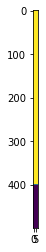

In [499]:
plt.imshow(R1stor[24,:,:])


In [507]:
#Because root growth here is independent of PGPR colonization, the plant is not able to maintain 
#the growth rate of R1 after it has depleted the soil's natural reserves of the hormone and 
#grows at a slowed rate after that point.
Bstor = np.full([n,m],0)#initial bacteria population evenly dispersed within soil to mimic bacteriazation of soil
PNstor = 1800

#Variables and matrices for root growth
R1 = 2125

time = np.linspace(0,t,t)
U = (1/300)
root2 = np.zeros([n,m])
root2[0,:] = 1


#For loop that grows root depending on root growth equation and generations
for i in range(0,time.size):
    
    R = PGPR(Bstor,root2,PNstor)
    
    L = R*(1-(2.71828)**(-U*(time[i])))
    
    

    
    print("Investigating gen", i)
    clear_output(wait = True)
    R2stor[i,:,:] = root2
           

Investigating gen 24


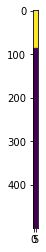

In [508]:
plt.imshow(R2stor[12,:,:])

In [500]:
#Function governing when hormone runs out 
def PGPR(Bstor,root,PNstor):
    bottom = np.max(np.where(root == 1)[0])
    bBott = np.sum(Bstor[bottom,:])
    
    #Governs root growth, if average bacteria/cell is above or equal to theta, root growth is rapidly increased
    if (bBott/m) >= theta:
        PNstor += bBott
    #if current store of nutrients greater than amount consumed by each cell in bottom row of root
    if PNstor >= m*PC:
        R = R1
        PNstor -=m*PC
    else:
        R = 0
    return(R)

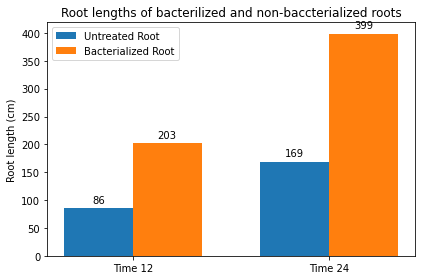

In [512]:
#plotting of bar graph
bact12 = np.max(np.where(R1stor[12,:,:] == 1)[0])
bact24 = np.max(np.where(R1stor[24,:,:] == 1)[0])
nobact12 = np.max(np.where(R2stor[12,:,:] == 1)[0])
nobact24 = np.max(np.where(R2stor[24,:,:] == 1)[0])


labels = ['Time 12', "Time 24"]
bactRoot = [bact12,bact24]
noBactRoot = [nobact12,nobact24]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noBactRoot, width, label='Untreated Root')
rects2 = ax.bar(x + width/2, bactRoot, width, label='Bacterialized Root')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Root length (cm)')
ax.set_title('Root lengths of bacterilized and non-baccterialized roots')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()